In [1]:
%matplotlib inline


Fit Multiple Data Sets
======================

Fitting multiple (simulated) Gaussian data sets simultaneously.

All minimizers require the residual array to be one-dimensional. Therefore, in
the ``objective`` we need to ```flatten``` the array before returning it.

TODO: this should be using the Model interface / built-in models!


In [1]:
import matplotlib.pyplot as plt
import numpy as np

import lmfit
from lmfit import Parameters, minimize, report_fit

In [103]:
def chi(x, ld, tg, f):
    """Gaussian lineshape."""
    return np.exp(-x / ld * np.sqrt(1 +  1j * tg * 2 * np.pi * f))


def chi_dataset(params, i, x):
    """Calculate Gaussian lineshape from parameters for data set."""
    ld = params['ld_%i' % (i+1)]
    tg = params['tg_%i' % (i+1)]
    f = params['f_%i' % (i+1)]
    return chi(x, ld, tg, f)


def objective_single(params, x, data):
    """Calculate total residual for fits of Gaussians to several data sets."""
    ndata = data.shape[0]
    resid = 0.0*data[:]

    resid_c = []
    # make residual per data set
    for i in range(ndata):
        resid[i, :] = data[i, :] - chi_dataset(params, i, x)
        if resid[i].dtype == np.complex:
            resid_c.append(resid[i].ravel().view(np.float))
#         print(np.shape(resid))
    # now flatten this to a 1D array, as minimize() needs
    resid_c = np.array(resid_c)
    return resid_c.flatten()

def objective_multiple(params, x, data):
    """Calculate total residual for fits of Gaussians to several data sets."""
    ndata = data.shape[0]
    resid = 0.0*data[:]

    resid_c = []
    # make residual per data set
    for i in range(ndata):
#         print(resid[i].shape)
        resid[i] = data[i] - chi_dataset(params, i, x[i])
        if resid[i].dtype == np.complex:
            resid_c.append(resid[i].ravel().view(np.float))
#         print(np.shape(resid))
    # now flatten this to a 1D array, as minimize() needs
    resid_c = np.array(resid_c)
    return np.concatenate(resid_c).ravel()

Create five simulated Gaussian data sets



In [137]:
# Simulating data with a single x array
np.random.seed(121)

x = np.linspace(0, 30 ,40)

data = []
for i in np.arange(2):
    params = Parameters()
    ld = 10 + 30*np.random.rand()
    tg = 1 + 20*np.random.rand()
    f = 2 * i + 1
    dat = chi(x, ld, tg, f) + np.random.normal(size=x.size, scale=0.001)
    data.append(dat)
    print(ld, tg, f)
data = np.array(data)

13.339924840157332 5.215351490856618 1
25.351417130035937 19.761681356341203 3


In [305]:
# Simulating data with multiple x arrays
np.random.seed(121)

x = []
x.append(np.linspace(0, 20 ,20))
x.append(np.linspace(0, 20 ,40))
x.append(np.linspace(0, 10 ,20))
# x.append(np.linspace(0, 15 ,30))
# print(x)
x = np.reshape(np.tile(np.linspace(0,30,30),3),(3,30))
data = []
for i in np.arange(3):
    params = Parameters()
    ld = 10 + 30*np.random.rand()
    tg = 1 + 2.5*np.random.rand()
    f =  i + 1
    dat = chi(x[i], ld, tg, f) + np.random.normal(size=x[i].size, scale=0.001)
    data.append(dat)
    print(ld, tg, f, 2*np.pi*f*tg)
data = np.array(data)

13.339924840157332 1.5269189363570772 1 9.593914626173069
31.338960176070202 1.138660410143581 2 14.308828717762461
33.90412991503634 1.6780336527677222 3 31.63018917606913


Create five sets of fitting parameters, one per data set



In [134]:
fit_params = Parameters()
for iy, y in enumerate(data):
    fit_params.add('ld_%i' % (iy+1), value=20, min=0.0, max=200)
    fit_params.add('tg_%i' % (iy+1), value=3, min=0.01, max=100.0)
    fit_params.add('f_%i' % (iy+1), value= iy +1, vary=False)

Constrain the values of sigma to be the same for all peaks by assigning
sig_2, ..., sig_5 to be equal to sig_1.



In [5]:
# for iy in (2, 3, 4, 5):
#     fit_params['sig_%i' % iy].expr = 'si

Run the global fit and show the fitting result



In [206]:
out = minimize(objective_single, fit_params, args=(x, data))
report_fit(out.params)

[[Variables]]
    ld_1:  13.2502204 (init = 20)
    tg_1:  5.13561439 (init = 3)
    f_1:   1 (fixed)
    ld_2:  27.2579307 (init = 20)
    tg_2:  34.2877275 (init = 3)
    f_2:   2 (fixed)
    ld_3:  20.0000000 (init = 20)
    tg_3:  3.00000000 (init = 3)
    f_3:   3 (fixed)


Plot the data sets and fits



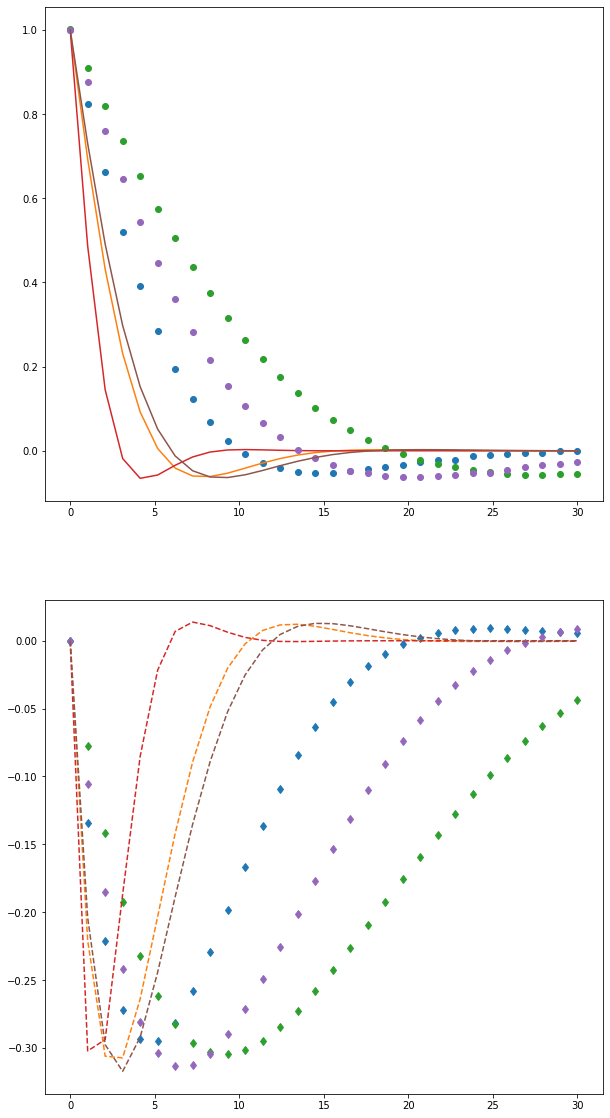

In [306]:
# plotting from multiple x array
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,20))
for i in range(3):
    y_fit = chi_dataset(out.params, i, x[i])
    ax1.plot(x[i], data[i].real, 'o', x[i], y_fit.real, '-')
    ax2.plot(x[i], data[i].imag, 'd', x[i], y_fit.imag, '--')
plt.show()

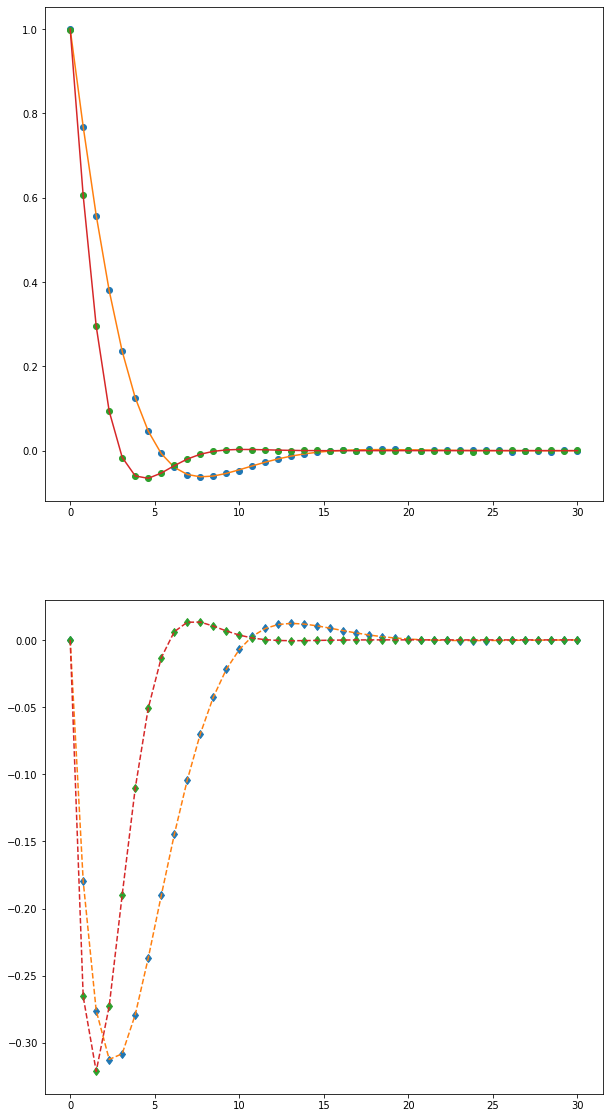

In [211]:
# plotting from single x array
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,20))
for i in range(2):
    y_fit = chi_dataset(out.params, i, x)
    ax1.plot(x, data[i].real, 'o', x, y_fit.real, '-')
    ax2.plot(x, data[i].imag, 'd', x, y_fit.imag, '--')
plt.show()

In [149]:
import sys
import inspect

In [ ]:
def test_func(x, a, b ,c):
    def argnames():
        

In [150]:
inspect.signature(chi)

<Signature (x, ld, tg, f)>

In [161]:
pos_args = []
kw_args = {}
keywords_ = None
sig = inspect.signature(chi)

for fnam, fpar in sig.parameters.items():
    if fpar.kind == fpar.POSITIONAL_OR_KEYWORD:
        if fpar.default == fpar.empty:
            pos_args.append(fnam)
        else:
            kw_args[fnam] = fpar.default
    elif fpar.kind == fpar.VAR_POSITIONAL:
        raise ValueError("varargs '*%s' is not supported" % fnam)

In [277]:
initial_values = [15, .1, 2]
vary_params = [True, True, False]
bounds = [(0, None), (0, None), (0, None)]

n_params = len(pos_args[1:])
n_dat = data.shape[0]

flag = 0
lens = [len(initial_values), len(vary_params), len(bounds)]
if all(x == n_params * n_dat for x in lens):
    print('Individual parameters')
    flag = 2
elif all (x == n_params for x in lens):
    print('One set of parameters')
    flag =1
else:
    print('Inadequate number of initial values, bounds, or parameter variability arguments')

dum_params = Parameters()
for i in np.arange(n_dat):
    for j, p_name in enumerate(pos_args[1:]):
        print(p_name + '_%i' % (i+1))
        # 
        if flag == 2:
            dum_params.add(p_name + '_%i' % (i+1), value=initial_values[i+j],
                           vary=vary_params[i+j], min=bounds[i+j][0],
                           max=bounds[i+j][1])
        elif flag ==1:
            dum_params.add(p_name + '_%i' % (i+1), value=initial_values[j],
                           vary=vary_params[j], min=bounds[j][0],
                           max=bounds[j][1])
        else:
            dum_params.add(p_name + '_%i' % (i+1))
        
dum_params

One set of parameters
ld_1
tg_1
f_1
ld_2
tg_2
f_2
ld_3
tg_3
f_3


name,value,initial value,min,max,vary
ld_1,15.0000000,15,0.00000000,inf,True
tg_1,0.10000000,0.1,0.00000000,inf,True
f_1,2.00000000,2,0.00000000,inf,False
ld_2,15.0000000,15,0.00000000,inf,True
tg_2,0.10000000,0.1,0.00000000,inf,True
f_2,2.00000000,2,0.00000000,inf,False
ld_3,15.0000000,15,0.00000000,inf,True
tg_3,0.10000000,0.1,0.00000000,inf,True
f_3,2.00000000,2,0.00000000,inf,False


In [201]:
initial_values = [15, .1, 2]
vary_params = [True, True, False]
bounds = [(0, None), (0, None), (0, None)]

flag = 0
lens = [len(initial_values), len(vary_params), len(bounds)]
if all(x == n_params * n_dat for x in lens):
    print('Individual parameters')
    flag = 2
elif all (x == n_params for x in lens):
    print('One set of parameters')
    flag =1
else:
    print('Inadequate number of initial values, bounds, or parameter variability arguments')

One set of parameters


In [184]:
lens = [len(initial_values), len(vary_params), len(bounds)]
all(x == n_params for x in lens)

True

In [247]:
def dum_func(x, a, b, c):
    print(a,b,c)
    print(type(x))
    print(type(a), type(b), type(c))
    return np.exp(-x/a + b) + c
    

In [312]:
def dataset_fun(params, i, x, fun):
    """Calculate a function's lineshape from parameters for a single data set.
    
    Parameters
    ----------
    params : :class:`~lmfit.parameter.Parameters`
        Contains the Parameters for the model.
    i : int
        Index of the data set being evauluated.
    x : np.ndarray
        Array of independent variable values.
    fun: callable
        Function to be evaluated following the form fun(x, *args)
        
    Returns
    -------
    np.ndarray
        Values from evaluating the callable function with the given data set
        parameters and independent variable array/
"""

    args = []
    for pname in params:
        # find all parameters with suffix for current index
        if pname.endswith(str(i+1)):
            args.append(params[pname])

    return fun(x, *args)

In [313]:
def objective_fun(params, x, data, fun):
    """Calculate a residuals array for a given model function
    
    Parameters
    ----------
    params : :class:`~lmfit.parameter.Parameters`
        Contains the Parameters for the model.
    x : list or np.ndarray
        Array or list of arrays of independent variable values.
    data : list or np.ndarray
        Array or list of arrays of data sets to be fit.
    fun: callable
        Function to be evaluated following the form fun(x, *args).
        
    Returns
    -------
    np.ndarray
        1-D array of residuals for the given model function.
"""
    ndata = np.shape(data)[0]
    resid = 0.0*data[:]
    
    resid_c = []
    # make residual per data set
    for i in range(ndata):
        resid[i] = data[i] - dataset_fun(params, i, x[i], fun)
        if resid[i].dtype == np.complex:
            # convert to floats as required by minimize()
            resid_c.append(resid[i].ravel().view(np.float))
    # change to array so residuals can be flattened as needed by minimize
    resid_c = np.array(resid_c)
    return np.concatenate(resid_c).ravel()

In [282]:
isinstance(x, np.ndarray)

False

In [311]:
dum1 = [10, 30 ,50]
np.shape(dum1)[0]

3

In [302]:
x = np.reshape(np.tile(np.linspace(0,20,30),3), (3,30))

In [314]:
func_dataset(fit_params, 0, x[0], chi)
# objective_func(fit_params, x, data, chi)
minimize(objective_function, fit_params, args=(x, data, chi))

In [296]:
type(dataset_function(fit_params, 0, x[0], chi))

numpy.ndarray